In [2]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'


    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

## Set-up
import packages and setup the CUDA

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
    current_device = torch.cuda.current_device()
    print("Current GPU device:", torch.cuda.get_device_name(current_device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

Current GPU device: Quadro RTX 5000
using device: cuda


Define functions

In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def threshold_mask(probability_mask, threshold=0.5):
    """
    convert the mask to a binary img
    """
    binary_mask = (probability_mask >= threshold).astype(int)
    return binary_mask

def dice_coefficient(pred_mask, true_mask):
    """
    Calculate the Dice coefficient between two binary masks.
    """
    intersection = np.sum(pred_mask * true_mask)
    dice = (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def calculate_iou(binary_mask1, binary_mask2):
    # 计算交集的像素数量
    intersection = np.logical_and(binary_mask1, binary_mask2).sum()
    # 计算并集的像素数量
    union = np.logical_or(binary_mask1, binary_mask2).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # 防止除以0的情况
    return intersection / union

In [6]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "root/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

/root/myenv/lib/python3.12/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


## Define File Path


In [7]:
image_folder = '/root/Dataset/BUS_all_dataset_resize/test/images'  # path of all the test images
label_folder = '/root/Dataset/BUS_all_dataset_resize/test/labels'  # path of ground truth masks
result_folder = '/root/Dataset/BUS_all_dataset_resize/test/results'  # path of evaluation result images

## Iterate over the entire data set and Calculate Evaluation Coefficients

Single Point Prompt

In [8]:
# generate 10 random numbers to show segment examples
random_numbers = [random.randint(1, 400) for _ in range(10)]

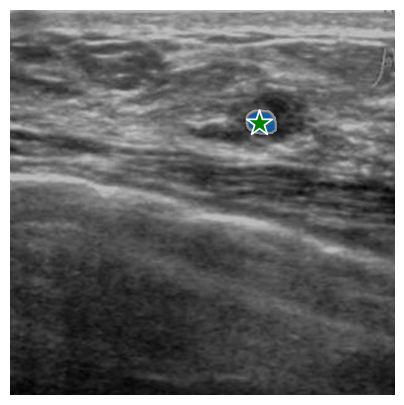

Dice coefficient: 0.25662752693378527


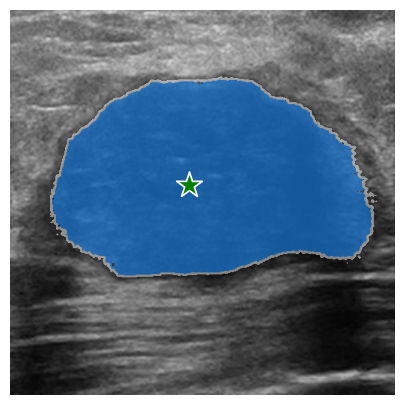

Dice coefficient: 0.9192551525550362


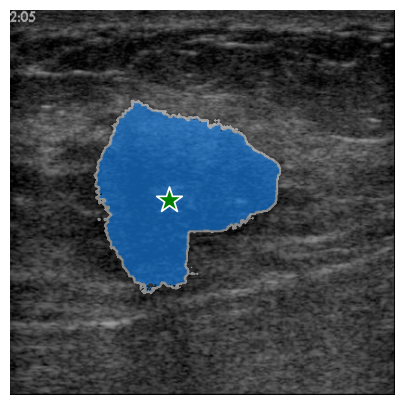

Dice coefficient: 0.7945090112851608


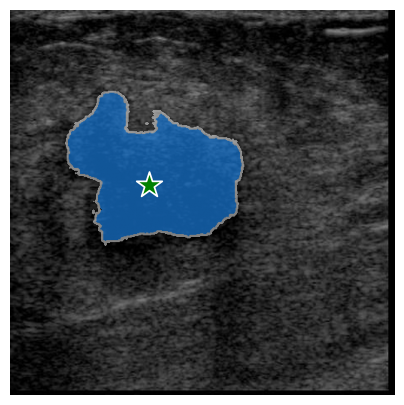

Dice coefficient: 0.8006365625621643


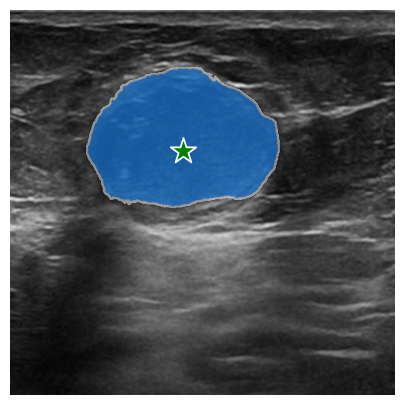

Dice coefficient: 0.8982135882372883


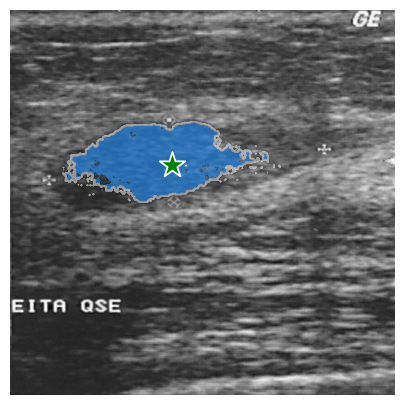

Dice coefficient: 0.6876965040498053


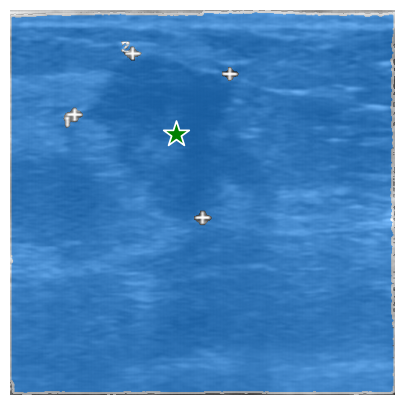

Dice coefficient: 0.22821103682500973


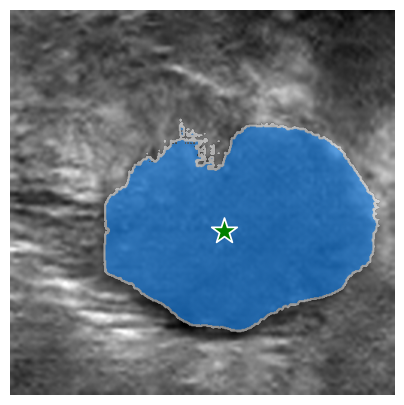

Dice coefficient: 0.8866647732184093


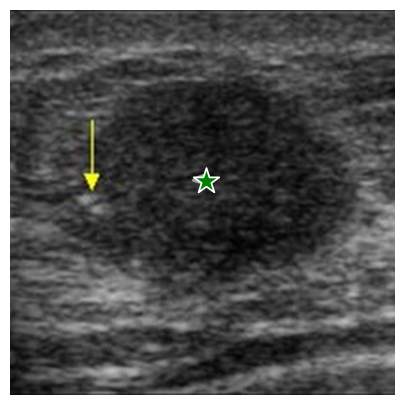

Dice coefficient: 0.004921139559001829


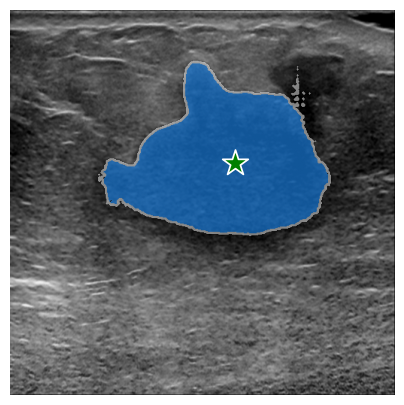

Dice coefficient: 0.8482798972599344
mean dice score of point prompt:  0.6656438210736575


In [10]:
dice_point = []  # A list to store the dice values
IoU_point = []
result_point=[]
count = 0
for filename in os.listdir(image_folder):
  if filename.endswith(".png") or filename.endswith(".jpg"):  # only operate image file
    image_path = os.path.join(image_folder, filename)
    label_path = os.path.join(label_folder, filename)

    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    gt = Image.open(label_path)
    gt = np.array(gt.convert("L"))
    gt = gt / 255  # convert to 0 or 1 img

    # find all white pixels
    white_pixels = np.column_stack(np.where(gt == 1))
    # find the enter of the gt mask
    if len(white_pixels) > 0:
        center_x, center_y = white_pixels.mean(axis=0)
        # print(f"Geometric center of white region: {center}")
    else:
        print("invalid mask")

    predictor.set_image(image)
    input_point = np.array([[center_y, center_x]])  # note that is (y,x)
    input_label = np.array([1])

    ## model insert
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    ## model insert

    pred_mask = threshold_mask(masks)  # binary
    # Calculate Dice
    dice = dice_coefficient(pred_mask, gt)  # gt is ground_truth
    dice_point.append(dice)
    iou = calculate_iou(pred_mask, gt)
    IoU_point.append(iou)
    result_point.append({"Img Name":filename, "Dice":dice, "IoU":iou})

    if count in random_numbers:
      show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)
      print("Dice coefficient:", dice)

    count = count + 1

print('mean dice score of point prompt: ',np.mean(dice_point))
df_point = pd.DataFrame(result_point)
filename = "Performance_SinglePoint.csv"
dicefile_path = os.path.join(result_folder, filename)
df_point.to_csv(dicefile_path,index=True)

Single Box Prompt

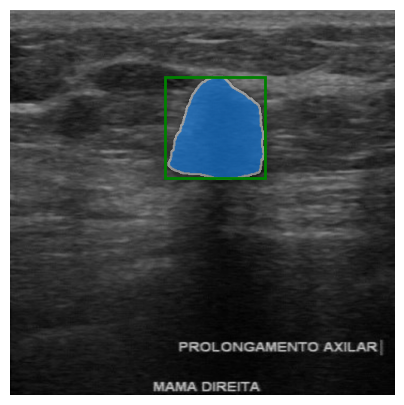

Dice:  0.9255510204081633
IoU:  0.8614192371979942


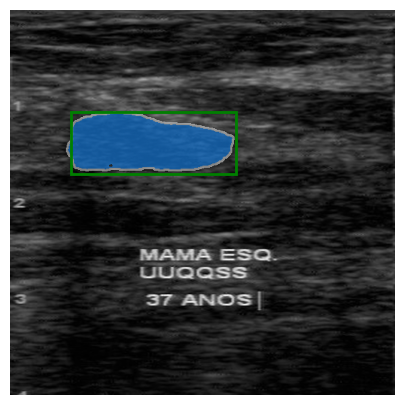

Dice:  0.9479687959964674
IoU:  0.9010842952081147


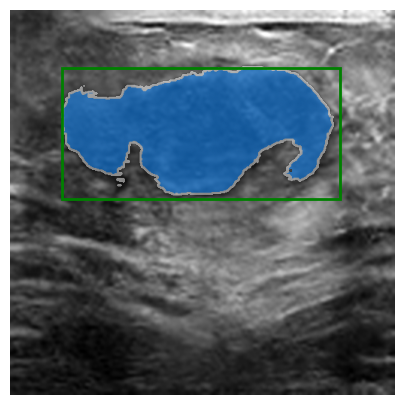

Dice:  0.9192933372441957
IoU:  0.8506409453421855


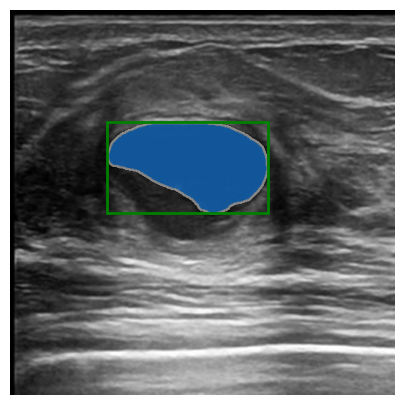

Dice:  0.973556016531706
IoU:  0.9268422170312168


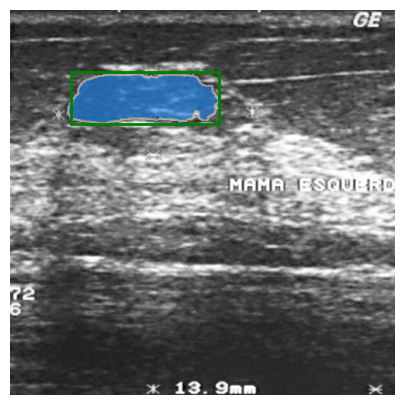

Dice:  0.950229953098675
IoU:  0.9051791446169862


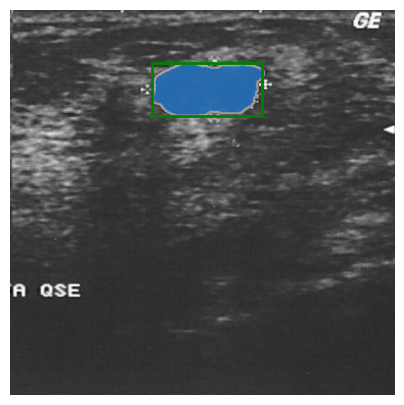

Dice:  0.9554163152187011
IoU:  0.9146383665936094


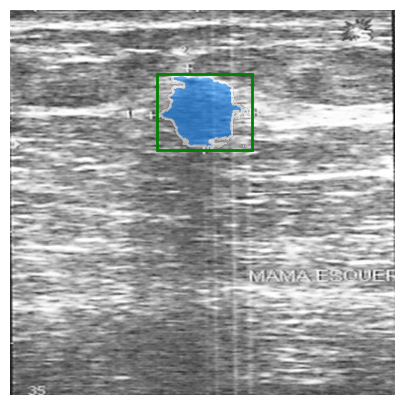

Dice:  0.8709910146258281
IoU:  0.7714650865574533


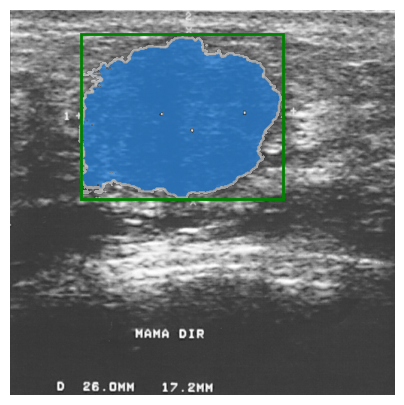

Dice:  0.9325646041387831
IoU:  0.8736496913580247


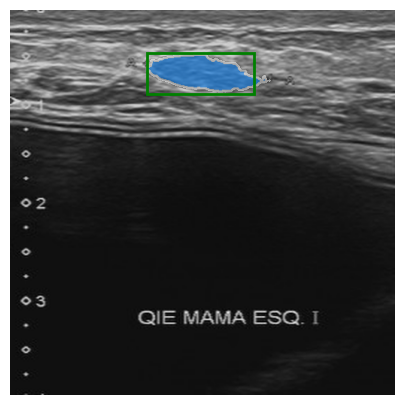

Dice:  0.9246648017748625
IoU:  0.8598851811984213


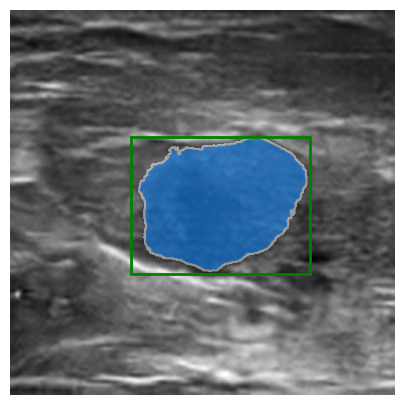

Dice:  0.9411364630058459
IoU:  0.8888175200342571
mean dice score of point prompt:  0.9206018262464701


In [ ]:
dice_box = []  # A list to store the dice values
IoU_box = []
result_box=[]
count = 0
for filename in os.listdir(image_folder):
  if filename.endswith(".png") or filename.endswith(".jpg"):  # only operate image file
    image_path = os.path.join(image_folder, filename)
    label_path = os.path.join(label_folder, filename)

    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    gt = Image.open(label_path)
    gt = np.array(gt.convert("L"))
    gt = gt / 255  # convert to 0 or 1 img

    # find all white pixels
    white_pixels = np.column_stack(np.where(gt == 1))
    # find the boundary
    if len(white_pixels) > 0:
        x_min, y_min = np.min(white_pixels, axis=0)
        x_max, y_max = np.max(white_pixels, axis=0)
    else:
        print("invalid mask")

    predictor.set_image(image)
    input_box = np.array([y_min, x_min, y_max, x_max])  # note that is (y,x)

    masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

    pred_mask = threshold_mask(masks)  # binary
    # Calculate dice and iou
    dice = dice_coefficient(pred_mask, gt)  # ground_truth 为你的真实 mask
    dice_box.append(dice)
    iou = calculate_iou(pred_mask, gt)
    IoU_box.append(iou)
    result_box.append({"Img Name":filename, "Dice":dice, "IoU":iou})

    if count in random_numbers:
      show_masks(image, masks, scores, box_coords=input_box)
      print("Dice: ",dice)
      print("IoU: ",iou)

    count = count + 1


print('mean dice score of point prompt: ',np.mean(dice_box))
df = pd.DataFrame(result_box)
filename = "Performance_SingleBox.csv"
filepath = os.path.join(result_folder, filename)
df.to_csv(filepath,index=True)